# Mount Google Drive to Google Colab

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


# Import Libraries

In [ ]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

# Create Train and Validation Set

In [ ]:
train_data_dir = "/content/drive/My Drive/VA Plants/Train"
test_data_dir = "/content/drive/My Drive/VA Plants/Test"

def split(img_height, img_width, batch_size):
  # Training Dataset
  train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      train_data_dir,
      validation_split = 0.1,
      subset = "training",
      seed = 49,
      image_size= (img_height, img_width),
      batch_size = batch_size
  )

  val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      train_data_dir,
      validation_split = 0.11,
      subset = "validation",
      seed = 49,
      image_size= (img_height, img_width),
      batch_size = batch_size
  )

  test_ds = tf.keras.preprocessing.image_dataset_from_directory(
      test_data_dir,
      seed = 49,
      image_size= (img_height, img_width),
      batch_size = batch_size
  )
    
  return train_ds, val_ds, test_ds

# Visualize the Data

Found 405 files belonging to 5 classes.
Using 365 files for training.
Found 405 files belonging to 5 classes.
Using 44 files for validation.
Found 45 files belonging to 5 classes.


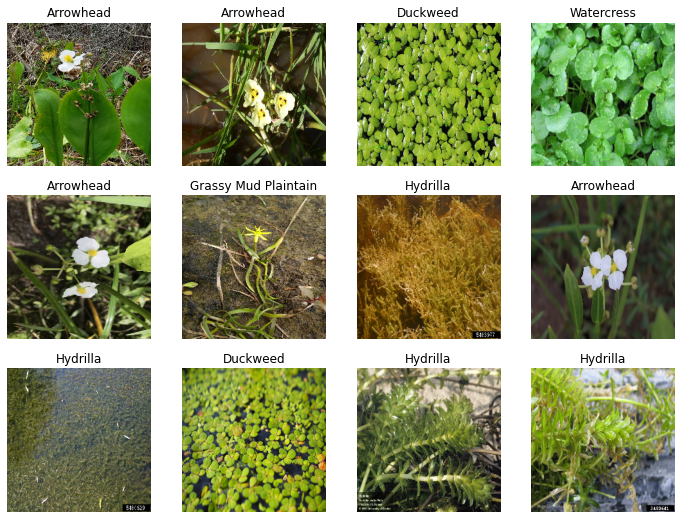

In [ ]:
import matplotlib.pyplot as plt
# https://keras.io/examples/vision/image_classification_from_scratch/

img_width, img_height, batch_size = 224, 224, 32
train_ds, val_ds, test_ds = split(img_width, img_height, batch_size)

class_names = ['Arrowhead',  'Duckweed', 'Grassy Mud Plaintain', 'Hydrilla',  'Watercress']
# Rows and columns are set to fit one training batch (32)
n_rows = int(batch_size/4)
n_cols = int(batch_size/n_rows)
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
        plt.subplots_adjust(wspace=.2, hspace=.2)

# Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
        tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(-0.1, 0.1)
    ]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


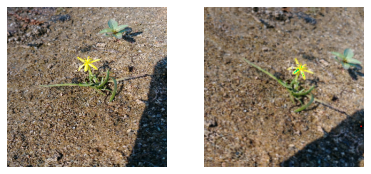

In [ ]:
def sample_augmentation(train_ds):
  plt.figure(figsize=(10, 10))
  for images, _ in train_ds.take(10):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, 1)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.axis("off")
    ax = plt.subplot(3, 3, 2)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

sample_augmentation(train_ds)

## EfficientNetB6

In [ ]:
inputs = tf.keras.layers.Input(shape=(img_width, img_height, 3))
x = data_augmentation(inputs)

ENetB6 = tf.keras.applications.EfficientNetB6(weights="imagenet", include_top=False, input_tensor=x)
# ENetB6 = tf.keras.applications.EfficientNetB6(weights="imagenet", include_top=False, 
#                                              input_shape=(img_width, img_height, 3))

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [ ]:
np.random.seed(49) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(49)
for layer in ENetB6.layers:
    layer.trainable = True

avg = keras.layers.GlobalAveragePooling2D()(ENetB6.output)
avg = keras.layers.BatchNormalization()(avg)

# Included dropout 
#top_dropout_rate = 0.2
#avg = keras.layers.Dropout(top_dropout_rate, name="final_dropout")(avg)

avg = keras.layers.Dropout(0.5, name="final_dropout")(avg)
avg = keras.layers.Flatten()(avg)
avg = keras.layers.Dense(256, activation="relu")(avg)
avg = keras.layers.Dropout(0.2)(avg)
avg = keras.layers.Dense(128, activation="relu")(avg)

output = keras.layers.Dense(5, activation="softmax")(avg)

model = keras.models.Model(inputs=ENetB6.input, outputs=output)

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)

model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

earlyStop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2,
                 patience = 5, min_lr = 0.000001)

history = model.fit(train_ds,
                    validation_data = val_ds,
                    callbacks = [earlyStop, reduce_lr],
                    epochs = 50)

Epoch 1/50
12/12 [==============================] - 55s 1s/step - loss: 1.7492 - accuracy: 0.2969 - val_loss: 1.4499 - val_accuracy: 0.4773
Epoch 2/50
12/12 [==============================] - 31s 1s/step - loss: 0.7620 - accuracy: 0.7439 - val_loss: 1.2397 - val_accuracy: 0.4091
Epoch 3/50
12/12 [==============================] - 31s 1s/step - loss: 0.3500 - accuracy: 0.8768 - val_loss: 1.2638 - val_accuracy: 0.3636
Epoch 4/50
12/12 [==============================] - 31s 1s/step - loss: 0.2603 - accuracy: 0.9178 - val_loss: 1.2352 - val_accuracy: 0.4318
Epoch 5/50
12/12 [==============================] - 31s 1s/step - loss: 0.2176 - accuracy: 0.9186 - val_loss: 1.3272 - val_accuracy: 0.4318
Epoch 6/50
12/12 [==============================] - 31s 1s/step - loss: 0.1949 - accuracy: 0.9330 - val_loss: 0.8807 - val_accuracy: 0.5909
Epoch 7/50
12/12 [==============================] - 31s 1s/step - loss: 0.0826 - accuracy: 0.9614 - val_loss: 0.7903 - val_accuracy: 0.6591
Epoch 8/50
12/12 [==

In [ ]:
model.evaluate(test_ds)

2/2 [==============================] - 43s 78ms/step - loss: 0.1106 - accuracy: 0.9778


[0.11062656342983246, 0.9777777791023254]

In [ ]:
model_name = "EfficientNetB6"
model_path = os.path.join("/content/drive/My Drive/VA Plants/Models", model_name)
model_path

tf.saved_model.save(model, model_path)
#Save: tf.saved_model.save(model, path_to_dir)
#Load: model = tf.saved_model.load(path_to_dir)

INFO:tensorflow:Assets written to: /content/drive/My Drive/VA Plants/Models/EfficientNetB6/assets
